<a href="https://colab.research.google.com/github/cstecker/politicsRLab/blob/main/Have%20confidence(intervals)%20in%20Wahlumfragen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Obamas lead is now within the margin of error" - Wahlumfragen und Fehlermargen


Um zu prüfen, ob eine Suppe gut gewürzt ist, löffelt man einen kleinen Teil und verkostet diesen. Die Idee dahinter ist, dass die Kostprobe *repräsentativ* für die gesamte Suppe ist. Jeder Happen sollte wie die gesamte Suppe schmecken, so die Annahme. Man trifft am Kochtopf also einen induktiven Schluss, indem anhand einer Stichprobe auf Eigenschaften der Population geschlossen wird - auch wenn man in diesem Jargon sicher seltener in einer Suppenküche parliert.
Wahlumfragen sind in diesem Sinne auch eine Suppenverkostung. Wir befragen einen kleinen Teil der Wählerschaft, ziehen also eine Stichprobe, um eine belastbare Ahnung zu bekommen, wie denn die gesamte Wählerschaft bei der nächsten Wahl abstimmen würde. 
Aber wie funktioniert das und was muss man bei der Interpretation solcher Stichproben beachten? Ein Suppenrezept haben wir nicht parat, aber wir können mal nachkochen bzw. simulieren, wie Umfragen funktionieren. Dazu generieren wir uns einen Beispieldatensatz. Wir sagen R, einen Datensatz mit 10000 Befragten zu basteln, die nach einer bestimmten Wahrscheinlichkeit eine bestimmte Parteien wählen. Diese Wahrscheinlichkeit passen wir an aktuelle Umfragen an. 

In [ ]:
# Wir basteln uns einen Datensatz der Sonntagsfrage
library(tidyverse)
library(tibble)

set.seed(123) #Der seed sorgt dafür, dass wir trotz zufälliger Erstellung der Stichprobe die gleiche Stichprobe erhalten. 

# Wir erstellen jetzt ein Element mit den Parteinamen und den Prozenten, die sie bei aktuellen Umfragen (von wahlrecht.de) bekommen.
parties <- tibble(party = c("CDU", "SPD", "Grüne", "FDP", "LINKE", "AfD", "Sonstige"),
                  percentage = c(0.31, 0.21, 0.16, 0.06, 0.045, 0.15, 0.065))

# Anhand dieser Prozente generieren wir nun eine Stichprobe von 10.000 Befragten. Die Prozente der Parteien werden hier als Wahrscheinlichkeit verwendet. 
# Bedeute, dass eine Person in der Stichprobe eine 31% Wahrscheinlichkeit hat den "Wert" CDU zugeordnet zu bekommen. 
poll <- sample(parties$party, 10000, replace = TRUE, prob = parties$percentage)

# Daraus erstellen wir nun einen Datensatz, welcher für alle "Befragten" eine Zahl sowie ihre "Wahlentscheidung" enthält.
population <- tibble(
  respondent = 1:10000,
  party_preference = poll)

# Schauen wir uns die Daten mal an
head(population)

Wir haben nun für 10000 simulierte Befragte eine Wahlabsicht. Wie würden denn die Stimmenanteile graphisch aussehen?

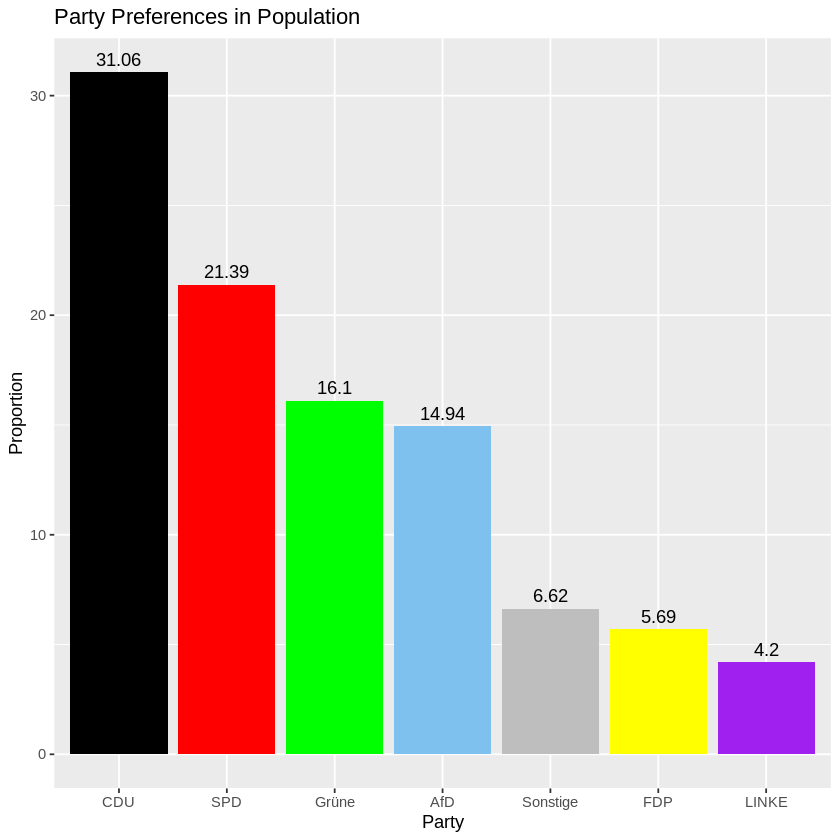

In [68]:
population %>% 
  # Count the number of observations for each party preference
  count(party_preference) %>% 
  # Calculate the percentage of observations for each party preference
  mutate(perc = n/sum(n)*100) %>% 
  # Create a bar plot of party preference percentages
  ggplot(aes(x = reorder(party_preference, desc(perc)), y = perc)) +
  geom_bar(stat = "identity", fill = c("skyblue2", "black", "yellow", "green", "purple", "red", "grey")) +
  # Add text labels with percentage values to the top of each bar
  geom_text(aes(label = perc, vjust = -.5)) +
  # Add axis and plot labels
  labs(x = "Party", y = "Proportion", title = "Party Preferences in Population")

Jetzt nehmen wir die 10000 simulierten Befragten als unsere Grundgesamtheit (also so wie alle Wahlberechtigten für die Sonntagsfrage). Nun ziehen wir eine Stichprobe aus dieser Grundgesamtheit

Nun ziehen wir eine Zufallsstichprobe (2%, also 200 Befragte) aus dieser Grundgesamtheit.

In [ ]:
sample <- population %>% 
  # Take a 2% random sample from the population data frame
  sample_frac(.02) %>% 
  # Count the number of observations for each party preference in the sample
  count(party_preference) %>% 
  # Calculate the percentage of observations for each party preference in the sample
  mutate(perc = n/sum(n)*100)
sample

Schauen wir uns mal an wie die Werte in der Stichprobe im Vergleich zur Grundgesamtheit ausfallen. Die Werte weichen leicht von der Grundgesamtheit ab.

In [ ]:
sample %>% 
  # Create a bar plot of party preference percentages
  ggplot(aes(x = reorder(party_preference, desc(perc)), y = perc)) +
  geom_bar(stat = "identity", fill = c("skyblue2", "black", "yellow", "green", "purple", "red", "grey")) +
  # Add text labels with percentage values to the top of each bar
  geom_text(aes(label = perc, vjust = -.5)) +
  # Add axis and plot labels
  labs(x = "Party", y = "Proportion", title = "Party Preferences in Population")

Führen Sie nun die beiden oberen Befehlsketten mehrfach aus, also zunächst eine Stichprobe ziehen und dann die Werte darstellen. Sie sehen, dass wir jeweils unterschiedliche Prozentwerte für die Parteien bekommen.
Wir irren uns also mit jeder Stichprobe etwas. Bei Wahlumfragen wollen wir wissen, wie groß diese Schwankung ist. Es wäre etwas teuer dazu mal eben 100 Sonntagsfragen zu starten. Aber wir leben ja hier in einer Simulation (!) und können uns auch das simulieren. Ziehen wir also mal kostenlos 100 Stichproben und schauen was passiert.

In [ ]:
# Set the seed to ensure reproducibility
set.seed(123)

# Specify the number of samples and the number of observations in each sample
n_reps <- 100 # Number of samples
n_obs <- 200 # Number of observations in each sample

# Create an empty tibble to store the sample results in a for-loop
many_samples <- tibble()

# For each of the 100 samples, create a data frame with 1000 observations sampled with replacement from the population
# Count the number of observations for each party preference in each sample
# Calculate the proportion of observations for each party preference in each sample
# Add a column to indicate the sample number
# Append the resulting data frame to the empty tibble
for (i in 1:n_reps) {
  sample_data <- population %>% 
    sample_n(n_obs, replace = TRUE) %>% 
    count(party_preference) %>% 
    mutate(prop = n / sum(n))
  sample_data$rep <- i
  many_samples <- rbind(many_samples, sample_data)
}

# Print the first few rows of the resulting tibble
head(many_samples)


Nun haben wir 100 Stichproben für unsere sieben Parteien, also insgesamt 700 Prozentwerte. Wie verteilen sich diese Werte um den wahren Wert in der Population?

In [ ]:
# Create a scatter plot to show the proportion of observations for each party preference in each sample
ggplot(many_samples, aes(x = rep, y = prop, color = party_preference)) +
  geom_point(size = 1) +
  # Add axis and plot labels
  labs(x = "Sample Number", y = "Proportion", color = "Party Preference") +
  # Customize the legend
  scale_color_manual(values = c("black", "red", "green", "yellow", "purple", "blue", "grey"),
                     labels = parties$party,
                     breaks = parties$party) +
  # Customize the y-axis
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  # Add a horizontal line to indicate the population percentages for each party
  geom_hline(data = parties, aes(yintercept = percentage, color = party), linetype = "dashed") +
  # Move the legend to the top of the plot and adjust the theme
  theme_classic() +
  theme(legend.position = "top")

Da schau her! Manchmal unterschätzen wir den Stimmenanteil, manchmal überschätzen wir ihn und manchmal treffen wir auch ins Schwarze bzw. Rote, Grüne, Gelbe usw.
Jetzt drehen Sie mal an unserer Stichprobenziehung oben. Ändern Sie mal die Zeile `n_obs <- 1000 # Number of observations in each sample`.
Stellen Sie mal 100 ein, also `n_obs <- 100` und lassen Sie sich die Abbildung 
Oha, bei der kleinen Stichprobengröße fliegen uns die Punkte wild um den wahren Wert. 
Und nun mal `n_obs <- 5000`. Bei wachsender Stichprobengröße wird es wieder akkurater. Je mehr Leute wir also befragen, desto größer unsere Chance nahe an den wahren Wert zu kommen.

Wir haben es beim Stichprobenziehen also immer mit einem gewissen Unsicherheitsfaktor zu tun. Diese Unsicherheit wollen wir quantifizieren. Dazu nutzen wir sogenannte Konfidenzintervalle. Das Konfidenzintervall gibt uns den Bereich an, in dem der wahre Wert (also in der Population) mit einer bestimmten Wahrscheinlichkeit liegt. Schauen wir uns das mal für die Stichprobenschwankungen der CDU an. Dazu werfen wir die einzelnen Stichprobenwerten auf einen Haufen. Der Berg türmt sich nun an den Stellen der x-Achse besonders auf, wo die entsprechenden Werte besonders häufig vorkamen. Wir sehen dass annähernd eine Normalverteilung (dazu später mehr) entsteht, die ihren Gipfel um den wahren Wert hat.

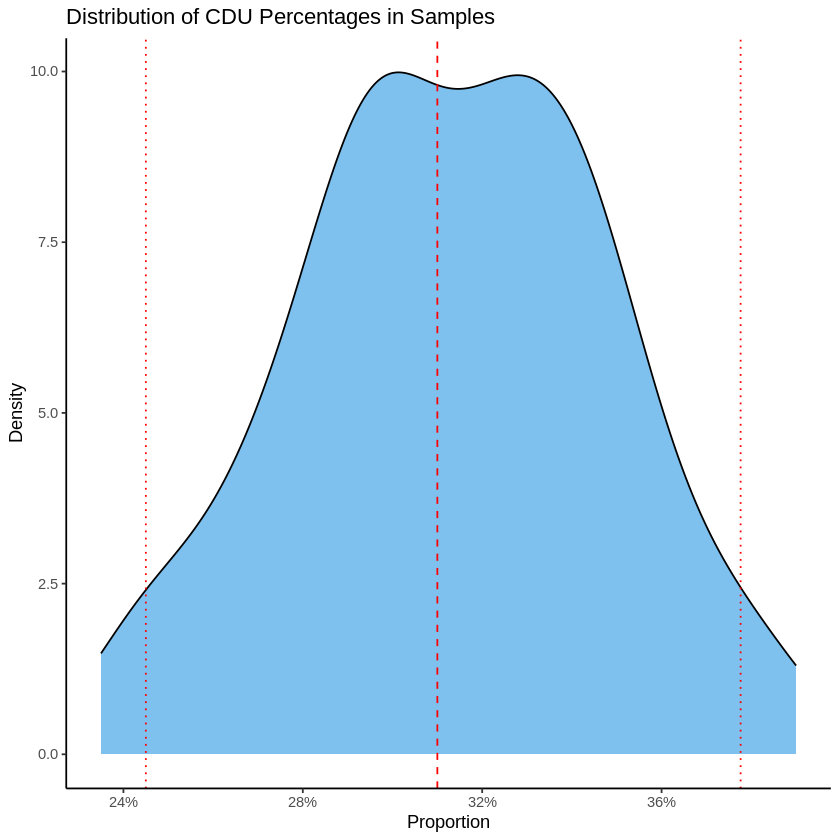

In [64]:
# Create a density plot to show the distribution of CDU percentages in the samples
density_plot <- ggplot(many_samples %>% filter(party_preference == "CDU"), aes(x = prop)) +
  geom_density(fill = "skyblue2", color = "black") +
  # Add axis and plot labels
  labs(x = "Proportion", y = "Density", title = "Distribution of CDU Percentages in Samples") +
  # Add a vertical line to indicate the population percentage for the CDU
  geom_vline(data = parties %>% filter(party == "CDU"), aes(xintercept = percentage), 
             linetype = "dashed", color = "red") +
  # Customize the x-axis
  scale_x_continuous(labels = scales::percent_format(accuracy = 1)) +
  # Customize the theme
  theme_classic()

# Calculate the 95% confidence interval for the CDU percentages
cdu_ci <- many_samples %>% 
  filter(party_preference == "CDU") %>% 
  summarise(lower = quantile(prop, 0.025),
            upper = quantile(prop, 0.975))

# Calculate the density values manually for the shaded area
cdu_density <- density(many_samples %>% filter(party_preference == "CDU") %>% pull(prop))
cdu_density_df <- data.frame(x = cdu_density$x, y = cdu_density$y)
cdu_density_df$y_scaled <- cdu_density_df$y / max(cdu_density_df$y)

# Add a shaded area to represent the 95% confidence interval
density_plot +
  # Add vertical dotted lines for the confidence interval
  geom_vline(xintercept = cdu_ci$lower, linetype = "dotted", color = "red") +
  geom_vline(xintercept = cdu_ci$upper, linetype = "dotted", color = "red")

Die mittlere vertikale Linie gibt den Wert der CDU-Unterstützung in der Population. Die beiden linken und rechten Linien geben die Grenzen des Konfidenzintervals. Wir können uns auch die Zahlen ansehen:

In [53]:
cdu_ci

lower,upper
<dbl>,<dbl>
0.245,0.377625


Das bedeutet, dass man mit einer Wahrscheinlichkeit von 95% sagen kann, dass der wahre Stimmenanteil der CDU in der Population Zielgruppe zwischen den Werten liegt die in der Spalte `lower` und `upper` aufgeführt sind.

Eine Pointe ist nun, dass sich Konfidenzintervalle zwischen verschiedenen Parteien überschneiden können. 

In [ ]:
# Define a set of x values to use for the density approximation
x_values <- seq(0, 1, length.out = 1000)

# Calculate the density distributions for the CDU and the SPD
cdu_density <- density(many_samples %>% filter(party_preference == "CDU") %>% pull(prop))
spd_density <- density(many_samples %>% filter(party_preference == "SPD") %>% pull(prop))

# Create functions that approximate the density estimates for the fixed x values
cdu_density_fun <- approxfun(cdu_density$x, cdu_density$y, method = "linear", yleft = 0, yright = 0)
spd_density_fun <- approxfun(spd_density$x, spd_density$y, method = "linear", yleft = 0, yright = 0)

# Calculate the density values for the fixed x values
density_df <- data.frame(x = x_values)
density_df$cdu_density <- cdu_density_fun(x_values)
density_df$spd_density <- spd_density_fun(x_values)
density_df$y_scaled <- density_df[, c("cdu_density", "spd_density")] %>% 
  apply(1, max) %>% 
  scale()

# Calculate the 95% confidence intervals for the CDU and SPD percentages
cdu_ci <- many_samples %>% filter(party_preference == "CDU") %>% 
  summarise(lower = quantile(prop, 0.025), upper = quantile(prop, 0.975))
spd_ci <- many_samples %>% filter(party_preference == "SPD") %>% 
  summarise(lower = quantile(prop, 0.025), upper = quantile(prop, 0.975))

# Create the density plot with confidence intervals for the CDU and SPD
ggplot(density_df, aes(x = x, y = y_scaled)) +
  geom_area(aes(y = cdu_density), fill = "skyblue2", alpha = 0.5) +
  geom_area(aes(y = spd_density), fill = "red", alpha = 0.5) +
  geom_vline(data = parties %>% filter(party %in% c("CDU", "SPD")), aes(xintercept = percentage), 
             linetype = "dashed", color = "black") +
  geom_vline(xintercept = cdu_ci$lower, linetype = "dotted", color = "black") +
  geom_vline(xintercept = cdu_ci$upper, linetype = "dotted", color = "black") +
  geom_vline(xintercept = spd_ci$lower, linetype = "dotted", color = "black") +
  geom_vline(xintercept = spd_ci$upper, linetype = "dotted", color = "black") +
  labs(x = "Proportion", y = "Density", 
       title = "Distribution of CDU and SPD Percentages in Samples") +
  xlim(0.1, 0.5) +
  theme_classic()
